- 사용금액이 1000불 이하인 데이터가 대부분이고 27000불 까지 종종 데이터가 있다.
- 앞의 get_preprocessed_df() 함수를 수정한다.

In [11]:
from sklearn.preprocessing import StandardScaler
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    return df_copy

- 함수를 수정 후 로지스틱회귀, LGBM 모델을 각각 학습/예측/평가 해본다.

In [12]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('### LGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도 : 0.9992, 정밀도 : 0.8654, 재현율 : 0.6081, F1 :0.7143, ROC-AUC : 0.8040
### LGBM 예측 성능
오차 행렬
[[85289     6]
 [   36   112]]
정확도 : 0.9995, 정밀도 : 0.9492, 재현율 : 0.7568, F1 :0.8421, ROC-AUC : 0.8783


- 변화가 없다.
- 이번에는 StandardScaler가 아니라 로그 변환을 수행해 본다.
- get_preprocessed_df()를 수정 후 확인해본다.

In [13]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    return df_copy

In [14]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('### LGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   58    90]]
정확도 : 0.9992, 정밀도 : 0.8824, 재현율 : 0.6081, F1 :0.7200, ROC-AUC : 0.8040
### LGBM 예측 성능
오차 행렬
[[85290     5]
 [   35   113]]
정확도 : 0.9995, 정밀도 : 0.9576, 재현율 : 0.7635, F1 :0.8496, ROC-AUC : 0.8817


- 두 모델 약간씩 성능 개선이 됐지만 미비한 수준.


### < 이상치 데이터 제거 후 모델 학습/예측/평가 >

- 이상치를 찾는 방법은 여러가지가 있지만 IQR(Inter Quantile Range) 방식을 적용해본다.
- IQR은 사분위 값의 편차를 이용하는 기법. 박스플롯으로 시각화할 수 있다.
- 25% 구간인 Q1, ~75% 구간잉ㄴ Q3의 범위를 IQR 이라고 한다.
- IQR을 이용해 이상치 데이터를 검 출하는 방식은 보통 IQR에 1.5를 곱해 생성된 범위를 이용해서 최댓값과 최솟값을 결정한 뒤 최댓값을 초과하거나 최솟값에 미달하는 데이터를 이상치 데이터로 판단한다.
- 경우에 따라 1.5가 아닌 다름 값을 적용할 수도 있지만 보통은 1.5를 적용한다.

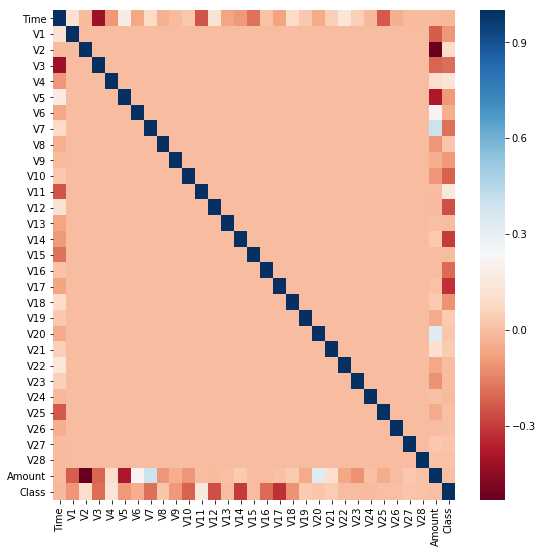

In [15]:
import seaborn as sns
plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')
plt.show()

- 히트맵에서 cmap을 'RdBu'로 설정하면 양의 상관관계에 가까울수록 색깔이 진한 파란색이 가깝고 음의 상관관계에 가까울수록 진한 빨간색에 가깝게 표현된다.
- Class 피처와 음의 상관관계가 가장 높은 피처는 V14 와 V17로 이 중 V14에 대해서 이상치를 찾아서 제거해보도록한다.

In [16]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출,1/4, 3/4 분위 지점을 np.percentile로 구한다.
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    #IQR을 구하고 IQR에 1.5를 곱해 최댓값, 최솟값 지점을 구한다.
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr*weight
    lowest_val= quantile_25-iqr_weight
    highest_val = quantile_75+iqr_weight
    
    # 최댓값보다 크거나 최솟값보다 작은 값을 이상치 데이터로 설저앟고 DataFrame index 반환
    outlier_index = fraud[(fraud<lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [17]:
outlier_index = get_outlier(df = card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스 ', outlier_index)

이상치 데이터 인덱스  Int64Index([8296, 8615, 9035, 9252], dtype='int64')


- 총 4개의 데이터가 추출됐다.  
- get_outlier()를 get_preprocessed_df 함수에 추가해 가공한 뒤 LGBM 모델에 적용해본다

In [18]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

In [19]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('### LGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85282    13]
 [   48    98]]
정확도 : 0.9993, 정밀도 : 0.8829, 재현율 : 0.6712, F1 :0.7626, ROC-AUC : 0.8355
### LGBM 예측 성능
오차 행렬
[[85291     4]
 [   25   121]]
정확도 : 0.9997, 정밀도 : 0.9680, 재현율 : 0.8288, F1 :0.8930, ROC-AUC : 0.9144


- 두 모델 모두 예측성능이 크게 향상됐다.
- 로지스틱 회귀는 60.81% -> 67.12%
- LGBM 은 76.35% -> 82.88%

### < SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가 >
- imbalanced-learn 패키지의 SMOTE클래스를 이용하여 구현

In [20]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포 : \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포 : 
 1    199020
0    199020
dtype: int64


- 이렇게 생성된 학습 데이터 세트를 기반으로 로지스틱 회귀 모델을 학습한 뒤 성능 평가를 해본다.

In [21]:
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train_over, X_test, y_train_over, y_test)

오차 행렬
[[82932  2363]
 [   11   135]]
정확도 : 0.9722, 정밀도 : 0.0540, 재현율 : 0.9247, F1 :0.1021, ROC-AUC : 0.9485


- 재현율이 92.47%로 크게 증가 했지만 반대로 정밀도가 5.4%로 급격하게 떨어졌다.
- 재현율이 높더라도 저조한 정밀도면 현실 업무에 적용할 수 없다.
- 이는 로지스틱 회귀 모델이 오버 샘플리으로 인해 실제 원본 데이터의 유형보다 많은 Class=1 데이터를 학습하여 실제 테스트 데이터 세트에서도 Class=1로 많이 예측하여 정밀도가 급격히 떨어졌다.
- 분류결정 임곗값에 따른 정밀도,재현율 곡선을 통해서 SMOTE로 학습된 로지스틱 회귀 모델을 살펴본다.


### 결정 트리 과적합

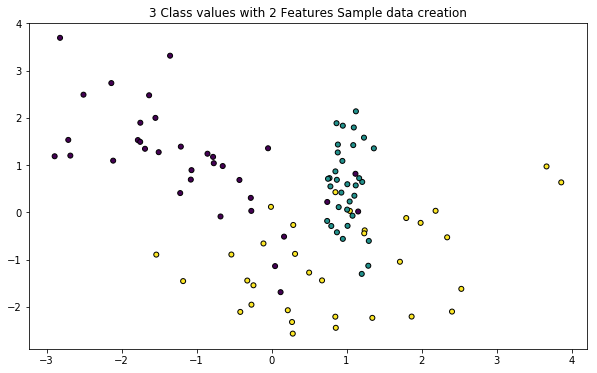

In [6]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.title('3 Class values with 2 Features Sample data creation')

# 2차원 시각화를 위해 피처는 2개 클래스는 3개
X_features, y_labels = make_classification(n_features=2, n_redundant=0, n_informative=2,
                                          n_classes=3, n_clusters_per_class=1, random_state=0)

# 그래프 형태로 2개의 피처로 2차원 좌표 시각화

plt.scatter(X_features[:,0], X_features[:,1], marker='o', c=y_labels, s=25, edgecolor='k')
plt.show()

In [7]:
import numpy as np

# Classifier의 Decision Boundary를 시각화 하는 함수
def visualize_boundary(model, X, y):
    fig,ax = plt.subplots()
    
    # 학습 데이타 scatter plot으로 나타내기
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()
    
    # 호출 파라미터로 들어온 training 데이타로 model 학습 . 
    model.fit(X, y)
    # meshgrid 형태인 모든 좌표값으로 예측 수행. 
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # contourf() 를 이용하여 class boundary 를 visualization 수행. 
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow', clim=(y.min(), y.max()),
                           zorder=1)

/home/jeongmyeong/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


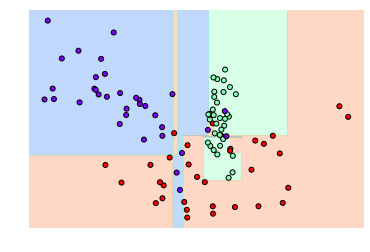

In [8]:
from sklearn.tree import DecisionTreeClassifier

# 특정한 트리 생성 제약 없는 결정 트리의 학습과 결정 경계 시각화
dt_clf = DecisionTreeClassifier().fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

- 이상치 데이터까지 분류하기 위해 분할이 자주 일어나 결정 기준 경계가 많다.

/home/jeongmyeong/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


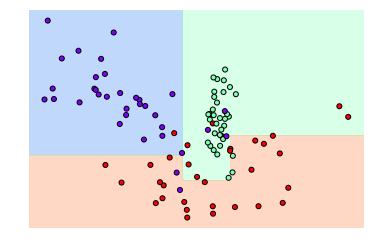

In [9]:
# min_samples_leaf=6으로 트리 생성 조건을 제약한 결정 경계 시각화
dt_clf = DecisionTreeClassifier(min_samples_leaf=6).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

- 이상치에 크게 반응하지 않으면서 좀 더 일반화된 분류 규칙에 따라 분류 됐다.